In [1]:
import os
import pathlib
import sys

default_dir_path = str(pathlib.Path(os.getcwd()).parent.absolute())

sys.path.append(default_dir_path)

from properties import ApplicationProperties

[2020-12-17 15:18:42,112][INFO][properties.py:22] Complete to apply the random seed, RANDOM_SEED : 777


In [2]:
from torch import optim
from torch.nn import functional as F
import torch

from dataset.factory import DatasetFactory
from dataset.nsl_kdd_dataset import NSLKDDDataFrameFactory, NSLKDDDataset
from domain.hyperparameters import Hyperparameters
from domain.metadata import ModelFileMetadata
from logger import logger
from model.factory import ModelFactory
from trainer.base import TrainerBase
from trainer.factory import TrainerFactory

In [3]:
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

In [4]:
device = "cpu"
data_name = "nsl_kdd"
model_name = "ae"
n_epoch = 1000

In [5]:
dataset_factory = DatasetFactory.create(data_name=data_name)

[2020-12-17 15:18:43,917][INFO][nsl_kdd_dataset.py:98] Success to load dataset dataframe : train
[2020-12-17 15:18:43,981][INFO][nsl_kdd_dataset.py:98] Success to load dataset dataframe : test
[2020-12-17 15:18:44,093][INFO][nsl_kdd_dataset.py:110] Success to load dataset dataframe : entire
[2020-12-17 15:18:44,447][INFO][nsl_kdd_dataset.py:255] Entire data size : 148517
[2020-12-17 15:18:44,448][INFO][nsl_kdd_dataset.py:256] Normal data size : 77054
[2020-12-17 15:18:44,449][INFO][nsl_kdd_dataset.py:257] Abnormal data size : 7146
[2020-12-17 15:18:44,449][INFO][nsl_kdd_dataset.py:258] Normal test data size : 7146
[2020-12-17 15:18:44,450][INFO][nsl_kdd_dataset.py:259] Training data size : 69908
[2020-12-17 15:18:44,451][INFO][nsl_kdd_dataset.py:260] Test data size : 14292
[2020-12-17 15:18:44,673][INFO][factory.py:77] Success to fit data with scaling
[2020-12-17 15:18:44,749][INFO][factory.py:84] Success to transform data with scaling
[2020-12-17 15:18:44,750][INFO][factory.py:153] Da

In [6]:
dataset_factory.test_dataset[0]

(tensor([-1.1789e-01, -2.6947e-02, -6.3119e-02, -1.0007e-02, -2.4359e-02,
         -7.1477e-03, -9.3671e-02, -2.6299e-02,  6.2874e-01, -1.5420e-02,
         -4.5432e-02, -3.1492e-02, -1.6766e-02, -2.9624e-02, -2.1860e-02,
         -5.4818e-02,  0.0000e+00, -3.7822e-03, -1.0915e-01, -3.7523e-01,
         -4.2118e-01, -1.3530e-01, -1.3296e-01, -2.0555e-01, -2.0817e-01,
          2.0522e-01, -1.9185e-01, -4.6833e-01,  1.0464e+00, -1.1254e+00,
         -1.4558e+00, -1.4429e-01, -4.7636e-01, -3.7897e-01,  4.8766e+00,
         -1.0250e-01, -2.2895e-01, -2.1953e-01, -1.3597e-01,  5.0363e-01,
         -4.7513e-01, -4.9952e-02, -3.0741e-02,  0.0000e+00, -5.7579e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.3012e-02, -3.8492e-01,  0.0000e+00, -8.2711e-02,
         -5.6187e-02,  0.0000e+00,  0.0000e+00, -8.8395e-02, -1.1232e-01,
         -2.7264e-01,  0.0000e+00,  0.0000e+00, -1.1757e+00,  0.0000e+00,
         -5.3488e-03,  0.0000e+00,  0.

In [7]:
dataset_factory.train_dataset[0]

(tensor([-0.1179, -0.0290, -0.0612, -0.0100, -0.0244, -0.0071, -0.0937, -0.0263,
          0.6287, -0.0154, -0.0454, -0.0315, -0.0168, -0.0296, -0.0219, -0.0548,
          0.0000, -0.0038, -0.1091, -0.1827, -0.2427, -0.1353, -0.1330, -0.2055,
         -0.2082,  0.2052, -0.1918, -0.4683, -1.1819,  0.6729,  0.5584, -0.3024,
         -0.3200, -0.0762, -0.1452, -0.1025, -0.2290, -0.2195, -0.1360,  0.5036,
         -0.4751, -0.0500, -0.0307,  0.0000, -0.0576,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -0.0230, -0.3849,  0.0000, -0.0827, -0.0562,
          0.0000,  0.0000, -0.0884, -0.1123, -0.2726,  0.0000,  0.0000,  0.8506,
          0.0000, -0.0053,  0.0000,  0.0000,  0.0000,  0.0000, -0.0038,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0491, -0.1890,  0.0000, -0.0505,  0.0000, -0.1550, -0.0100, -0.0038,
          0.0000, -0.0066, -0.3323,  0.0000, -0.0066,  0.0000,  0.0000,  0.0000,
         -0.1117, -0.0076, -

In [8]:
class AE(nn.Module):
    
    def __init__(self, input_size):  # 117
        super(AE, self).__init__()
        self.encoder_1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=64, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=16, bias=True),
            nn.Tanh()
        )
        self.decoder_1 = nn.Sequential(
            nn.Linear(in_features=16, out_features=32, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=64, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=input_size, bias=True),
            nn.Tanh()
        )
        
        self.he_init_weight()
        
    def forward(self, x):
        z = self.encoder_1(x)
        x_hat = self.decoder_1(z)
        return x_hat, z
    
    def he_init_weight(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight.data)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight.data)
            elif isinstance(module, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(module.weight.data)

In [10]:
from copy import deepcopy
import pickle
import time

from sklearn.metrics import roc_curve, auc
import torch

from domain.criterion import Criterion
from trainer.base import TrainerBase

time.time()


class AETrainer(TrainerBase):

    def __init__(self, model, model_file_metadata, train_loader, val_loader, test_loader, hyperparameters,
                 tqdm_env='script'):
        super(AETrainer, self).__init__(model, model_file_metadata, train_loader, val_loader, test_loader,
                                        hyperparameters, tqdm_env)

    def train(self):
        self.model.train()

        train_result_dict_list = list()
        val_result_dict_list = list()

        best_loss = 999999
        best_auc = 0
        best_loss_epoch = 0
        best_auc_epoch = 0

        # Set hyperparameters
        optimizer_cls = self.hyperparameters.optimizer_cls
        lr = self.hyperparameters.lr
        weight_decay = self.hyperparameters.weight_decay
        n_epoch = self.hyperparameters.n_epoch
        criterion = self.hyperparameters.criterion
        device = self.hyperparameters.device

        optimizer = optimizer_cls(self.model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in self.tqdm.tqdm(range(n_epoch)):
            total_loss = 0
            n_batch = 0

            for i, (data_batch, label_batch, abnormal_label_batch) in enumerate(self.train_loader):
                data_batch = data_batch.to(device)

                # Optimization
                optimizer.zero_grad()
                pred_data_batch, latent_data_batch = self.model(data_batch)
                loss = criterion(data_batch, pred_data_batch)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                n_batch += 1

            current_loss = total_loss / n_batch

            train_result_dict = dict(
                loss=current_loss
            )
            val_result_dict = self.validate()

            # Early stopping
            if val_result_dict['loss'] < best_loss:
                best_loss = val_result_dict['loss']
                best_loss_epoch = epoch
                # self.best_model_state_dict = deepcopy(self.model.state_dict())

            if best_auc < val_result_dict['auc']:
                best_auc = val_result_dict['auc']
                best_auc_epoch = epoch
                self.best_model = deepcopy(self.model.state_dict())

            # Print
            print(
                f"[Epoch {epoch}] "
                f"Train - loss : {round(train_result_dict['loss'], 7)} | "
                f"Val - AUC : {round(val_result_dict['auc'], 7)} | "
                f"Best AUC : {round(best_auc, 7)} (epoch : {best_auc_epoch})"
            )

            # Save Model & Record dict
            record_dict = dict(
                train_result_dict=train_result_dict,
                val_result_dict=val_result_dict
            )

            self.save_model(epoch=epoch)
            self.save_record(record=record_dict, epoch=epoch)

            # with open(self.model_file_metadata.get_save_record_file_path(epoch=epoch), "wb") as f:
            #     pickle.dump(record_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

            train_result_dict_list.append(train_result_dict)
            val_result_dict_list.append(val_result_dict)

        # Save last result
        entire_record_dict = dict(
            train_result_dict_list=train_result_dict_list,
            val_result_dict_list=val_result_dict_list
        )
        torch.save(self.best_model, self.model_file_metadata.get_best_model_file_path())

        # Save entire_record_dict
        with open(self.model_file_metadata.get_entire_record_file_path(), "wb") as f:
            pickle.dump(entire_record_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

        # Load best model
        self.load_best_model()

        return entire_record_dict

    def validate(self):
        self.model.eval()

        total_loss = 0
        n_batch = 0

        latent_data_list = list()
        reconstructino_error_list = list()
        abnormal_label_list = list()

        # Set hyperparameters
        criterion = self.hyperparameters.criterion
        device = self.hyperparameters.device

        for i, (data_batch, label_batch, abnormal_label_batch) in enumerate(self.val_loader):
            data_batch = data_batch.to(device)
            abnormal_label_batch = abnormal_label_batch.to(device)

            with torch.no_grad():
                pred_data_batch, latent_data_batch = self.model(data_batch)
                loss = criterion(data_batch, pred_data_batch).item()
                reconstruction_error_batch = Criterion.reconstruction_error(x=data_batch, x_hat=pred_data_batch)

            latent_data_list.append(latent_data_batch)
            reconstructino_error_list.append(reconstruction_error_batch)
            abnormal_label_list.append(abnormal_label_batch)

            total_loss += loss
            n_batch += 1

        latent_data_list = torch.cat(latent_data_list).cpu().numpy()
        reconstruction_error_list = torch.cat(reconstructino_error_list).cpu().numpy()
        abnormal_label_list = torch.cat(abnormal_label_list).cpu().numpy()

        fpr, tpr, thresholds = roc_curve(abnormal_label_list, reconstruction_error_list)
        auc_value = auc(fpr, tpr)

        current_loss = total_loss / n_batch

        return dict(loss=current_loss, auc=auc_value, latent_data_list=latent_data_list)


In [11]:
ae_model = AE(input_size=117)

In [12]:
ae_model.to(device)

AE(
  (encoder_1): Sequential(
    (0): Linear(in_features=117, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Tanh()
  )
  (decoder_1): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=117, bias=True)
    (5): Tanh()
  )
)

In [13]:
trainer = AETrainer(
    model=ae_model,
    model_file_metadata=ModelFileMetadata(model_name=model_name),
    train_loader=dataset_factory.train_dataloader,
    val_loader=dataset_factory.val_dataloader,
    test_loader=dataset_factory.test_dataloader,
    hyperparameters=Hyperparameters(
        optimizer_cls=optim.Adadelta,
        criterion=F.mse_loss,
        n_epoch=n_epoch,
        lr=1e-3,
        weight_decay=0,
        device=device
    ),
    tqdm_env="jupyter"
)

[2020-12-17 15:19:01,326][INFO][base.py:40] Model set to 'cpu'


In [14]:
# Adadelta (tanh)
result_dict = trainer.train()

[Epoch 0] Train - loss : 0.9208523 | Val - AUC : 0.9658233 | Best AUC : 0.9658233 (epoch : 0)
[Epoch 1] Train - loss : 0.8509037 | Val - AUC : 0.9659616 | Best AUC : 0.9659616 (epoch : 1)
[Epoch 2] Train - loss : 0.8067438 | Val - AUC : 0.9659597 | Best AUC : 0.9659616 (epoch : 1)
[Epoch 3] Train - loss : 0.7768108 | Val - AUC : 0.9660001 | Best AUC : 0.9660001 (epoch : 3)
[Epoch 4] Train - loss : 0.7540877 | Val - AUC : 0.9660629 | Best AUC : 0.9660629 (epoch : 4)
[Epoch 5] Train - loss : 0.7355725 | Val - AUC : 0.9661405 | Best AUC : 0.9661405 (epoch : 5)
[Epoch 6] Train - loss : 0.719589 | Val - AUC : 0.9662177 | Best AUC : 0.9662177 (epoch : 6)
[Epoch 7] Train - loss : 0.7055956 | Val - AUC : 0.9662956 | Best AUC : 0.9662956 (epoch : 7)
[Epoch 8] Train - loss : 0.6932234 | Val - AUC : 0.9663962 | Best AUC : 0.9663962 (epoch : 8)
[Epoch 9] Train - loss : 0.6823916 | Val - AUC : 0.9664778 | Best AUC : 0.9664778 (epoch : 9)
[Epoch 10] Train - loss : 0.6728826 | Val - AUC : 0.9665465 |

[Epoch 86] Train - loss : 0.5600049 | Val - AUC : 0.9661884 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 87] Train - loss : 0.559729 | Val - AUC : 0.9661822 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 88] Train - loss : 0.5594934 | Val - AUC : 0.9661769 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 89] Train - loss : 0.5591587 | Val - AUC : 0.9661703 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 90] Train - loss : 0.5589174 | Val - AUC : 0.966166 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 91] Train - loss : 0.558656 | Val - AUC : 0.966162 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 92] Train - loss : 0.5585187 | Val - AUC : 0.9661556 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 93] Train - loss : 0.5581657 | Val - AUC : 0.966151 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 94] Train - loss : 0.557891 | Val - AUC : 0.9661481 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 95] Train - loss : 0.5576482 | Val - AUC : 0.9661434 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 96] Train - loss : 0.5573857 | Val - AU

[Epoch 171] Train - loss : 0.5462505 | Val - AUC : 0.9658945 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 172] Train - loss : 0.5460936 | Val - AUC : 0.9658915 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 173] Train - loss : 0.5460212 | Val - AUC : 0.9658895 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 174] Train - loss : 0.5459088 | Val - AUC : 0.9658867 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 175] Train - loss : 0.5458263 | Val - AUC : 0.965884 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 176] Train - loss : 0.5457711 | Val - AUC : 0.9658814 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 177] Train - loss : 0.5457571 | Val - AUC : 0.9658789 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 178] Train - loss : 0.5455864 | Val - AUC : 0.9658768 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 179] Train - loss : 0.5456596 | Val - AUC : 0.9658737 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 180] Train - loss : 0.5453811 | Val - AUC : 0.9658717 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 181] Train - loss : 0.54

[Epoch 256] Train - loss : 0.5400424 | Val - AUC : 0.9657137 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 257] Train - loss : 0.5400011 | Val - AUC : 0.9657107 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 258] Train - loss : 0.5399342 | Val - AUC : 0.965709 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 259] Train - loss : 0.5398769 | Val - AUC : 0.9657069 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 260] Train - loss : 0.5398279 | Val - AUC : 0.9657052 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 261] Train - loss : 0.5397824 | Val - AUC : 0.9657035 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 262] Train - loss : 0.5397741 | Val - AUC : 0.9657008 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 263] Train - loss : 0.5396814 | Val - AUC : 0.9656988 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 264] Train - loss : 0.5396286 | Val - AUC : 0.9656968 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 265] Train - loss : 0.5395316 | Val - AUC : 0.9656954 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 266] Train - loss : 0.54

[Epoch 341] Train - loss : 0.5361967 | Val - AUC : 0.9655899 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 342] Train - loss : 0.5361935 | Val - AUC : 0.9655884 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 343] Train - loss : 0.5362325 | Val - AUC : 0.9655871 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 344] Train - loss : 0.5360494 | Val - AUC : 0.9655858 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 345] Train - loss : 0.5360041 | Val - AUC : 0.9655846 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 346] Train - loss : 0.5360308 | Val - AUC : 0.9655841 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 347] Train - loss : 0.5359721 | Val - AUC : 0.9655821 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 348] Train - loss : 0.5359253 | Val - AUC : 0.9655812 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 349] Train - loss : 0.5358568 | Val - AUC : 0.9655807 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 350] Train - loss : 0.5358792 | Val - AUC : 0.9655792 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 351] Train - loss : 0.5

[Epoch 426] Train - loss : 0.5334425 | Val - AUC : 0.965508 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 427] Train - loss : 0.5335778 | Val - AUC : 0.9655072 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 428] Train - loss : 0.533388 | Val - AUC : 0.9655066 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 429] Train - loss : 0.5333778 | Val - AUC : 0.9655059 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 430] Train - loss : 0.5334291 | Val - AUC : 0.9655054 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 431] Train - loss : 0.5332876 | Val - AUC : 0.9655046 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 432] Train - loss : 0.5333287 | Val - AUC : 0.9655039 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 433] Train - loss : 0.5332541 | Val - AUC : 0.9655033 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 434] Train - loss : 0.5332811 | Val - AUC : 0.9655039 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 435] Train - loss : 0.5332652 | Val - AUC : 0.9655031 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 436] Train - loss : 0.533

[Epoch 511] Train - loss : 0.5314186 | Val - AUC : 0.9654572 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 512] Train - loss : 0.5314336 | Val - AUC : 0.9654566 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 513] Train - loss : 0.5314081 | Val - AUC : 0.9654563 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 514] Train - loss : 0.531403 | Val - AUC : 0.9654562 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 515] Train - loss : 0.5313035 | Val - AUC : 0.9654556 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 516] Train - loss : 0.5312855 | Val - AUC : 0.9654549 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 517] Train - loss : 0.5313091 | Val - AUC : 0.965454 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 518] Train - loss : 0.5312573 | Val - AUC : 0.9654534 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 519] Train - loss : 0.5312586 | Val - AUC : 0.9654536 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 520] Train - loss : 0.5313489 | Val - AUC : 0.9654525 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 521] Train - loss : 0.531

[Epoch 596] Train - loss : 0.5298623 | Val - AUC : 0.9654115 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 597] Train - loss : 0.5298052 | Val - AUC : 0.9654109 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 598] Train - loss : 0.5298108 | Val - AUC : 0.9654101 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 599] Train - loss : 0.5302719 | Val - AUC : 0.9654096 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 600] Train - loss : 0.5299312 | Val - AUC : 0.965409 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 601] Train - loss : 0.5297646 | Val - AUC : 0.9654085 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 602] Train - loss : 0.5297199 | Val - AUC : 0.9654074 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 603] Train - loss : 0.529751 | Val - AUC : 0.9654075 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 604] Train - loss : 0.5297097 | Val - AUC : 0.9654068 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 605] Train - loss : 0.5296825 | Val - AUC : 0.965406 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 606] Train - loss : 0.5297

[Epoch 681] Train - loss : 0.5286105 | Val - AUC : 0.9653698 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 682] Train - loss : 0.5286143 | Val - AUC : 0.9653697 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 683] Train - loss : 0.528525 | Val - AUC : 0.9653693 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 684] Train - loss : 0.5286401 | Val - AUC : 0.9653686 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 685] Train - loss : 0.5285724 | Val - AUC : 0.9653684 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 686] Train - loss : 0.5285439 | Val - AUC : 0.9653678 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 687] Train - loss : 0.5284874 | Val - AUC : 0.9653672 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 688] Train - loss : 0.52849 | Val - AUC : 0.9653668 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 689] Train - loss : 0.5284939 | Val - AUC : 0.9653659 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 690] Train - loss : 0.5284684 | Val - AUC : 0.9653654 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 691] Train - loss : 0.5284

[Epoch 766] Train - loss : 0.5275582 | Val - AUC : 0.9653258 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 767] Train - loss : 0.5275956 | Val - AUC : 0.9653255 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 768] Train - loss : 0.5276022 | Val - AUC : 0.9653245 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 769] Train - loss : 0.5275133 | Val - AUC : 0.9653238 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 770] Train - loss : 0.5274969 | Val - AUC : 0.9653232 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 771] Train - loss : 0.5274824 | Val - AUC : 0.9653227 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 772] Train - loss : 0.5274541 | Val - AUC : 0.9653225 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 773] Train - loss : 0.527451 | Val - AUC : 0.9653215 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 774] Train - loss : 0.5275168 | Val - AUC : 0.9653215 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 775] Train - loss : 0.5274856 | Val - AUC : 0.965321 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 776] Train - loss : 0.527

[Epoch 851] Train - loss : 0.5267292 | Val - AUC : 0.9652866 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 852] Train - loss : 0.5318709 | Val - AUC : 0.9652861 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 853] Train - loss : 0.5266765 | Val - AUC : 0.9652859 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 854] Train - loss : 0.5266228 | Val - AUC : 0.9652856 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 855] Train - loss : 0.5267186 | Val - AUC : 0.9652851 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 856] Train - loss : 0.5266657 | Val - AUC : 0.9652844 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 857] Train - loss : 0.5266187 | Val - AUC : 0.9652837 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 858] Train - loss : 0.5268258 | Val - AUC : 0.9652834 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 859] Train - loss : 0.5266197 | Val - AUC : 0.9652831 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 860] Train - loss : 0.5265871 | Val - AUC : 0.9652828 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 861] Train - loss : 0.5

[Epoch 936] Train - loss : 0.5259975 | Val - AUC : 0.9652518 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 937] Train - loss : 0.5259587 | Val - AUC : 0.9652513 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 938] Train - loss : 0.5259042 | Val - AUC : 0.9652511 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 939] Train - loss : 0.5259023 | Val - AUC : 0.9652506 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 940] Train - loss : 0.5258737 | Val - AUC : 0.9652504 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 941] Train - loss : 0.5266886 | Val - AUC : 0.9652496 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 942] Train - loss : 0.5258788 | Val - AUC : 0.9652493 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 943] Train - loss : 0.5258629 | Val - AUC : 0.9652494 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 944] Train - loss : 0.5258483 | Val - AUC : 0.9652488 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 945] Train - loss : 0.5258396 | Val - AUC : 0.965248 | Best AUC : 0.9672078 (epoch : 26)
[Epoch 946] Train - loss : 0.52

[2020-12-18 01:41:41,422][INFO][base.py:96] Succeed to load best model, device: 'cpu'


In [15]:
result_dict

{'train_result_dict_list': [{'loss': 0.9208523471513657},
  {'loss': 0.8509036990270462},
  {'loss': 0.8067437975302987},
  {'loss': 0.776810807923976},
  {'loss': 0.754087674433634},
  {'loss': 0.7355725203348789},
  {'loss': 0.7195890305516922},
  {'loss': 0.7055955696706095},
  {'loss': 0.6932233604434153},
  {'loss': 0.6823915542331386},
  {'loss': 0.6728825519368632},
  {'loss': 0.6644048678895429},
  {'loss': 0.6569816092263643},
  {'loss': 0.6502237358307402},
  {'loss': 0.6441219142222568},
  {'loss': 0.6386283868408039},
  {'loss': 0.6336092602060915},
  {'loss': 0.628890777002483},
  {'loss': 0.6247178965595549},
  {'loss': 0.6210919038416046},
  {'loss': 0.617257693045063},
  {'loss': 0.613997405873147},
  {'loss': 0.6111532669130807},
  {'loss': 0.6082154802500656},
  {'loss': 0.6056497987334188},
  {'loss': 0.6033397087754865},
  {'loss': 0.601173489603898},
  {'loss': 0.5991626385249862},
  {'loss': 0.5973003728200151},
  {'loss': 0.5955428814724326},
  {'loss': 0.5939038

In [28]:
best_latent_data_list = result_dict["val_result_dict_list"][89]["latent_data_list"]
abnormal_label_list = [abnormal_label.item() for x, y, abnormal_label in dataset_factory.test_dataset]

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

pca.fit(best_latent_data_list)
pca_best_latent_data_list = pca.transform(best_latent_data_list)

pca_normal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in 
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 0
]
pca_abnormal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 1
]

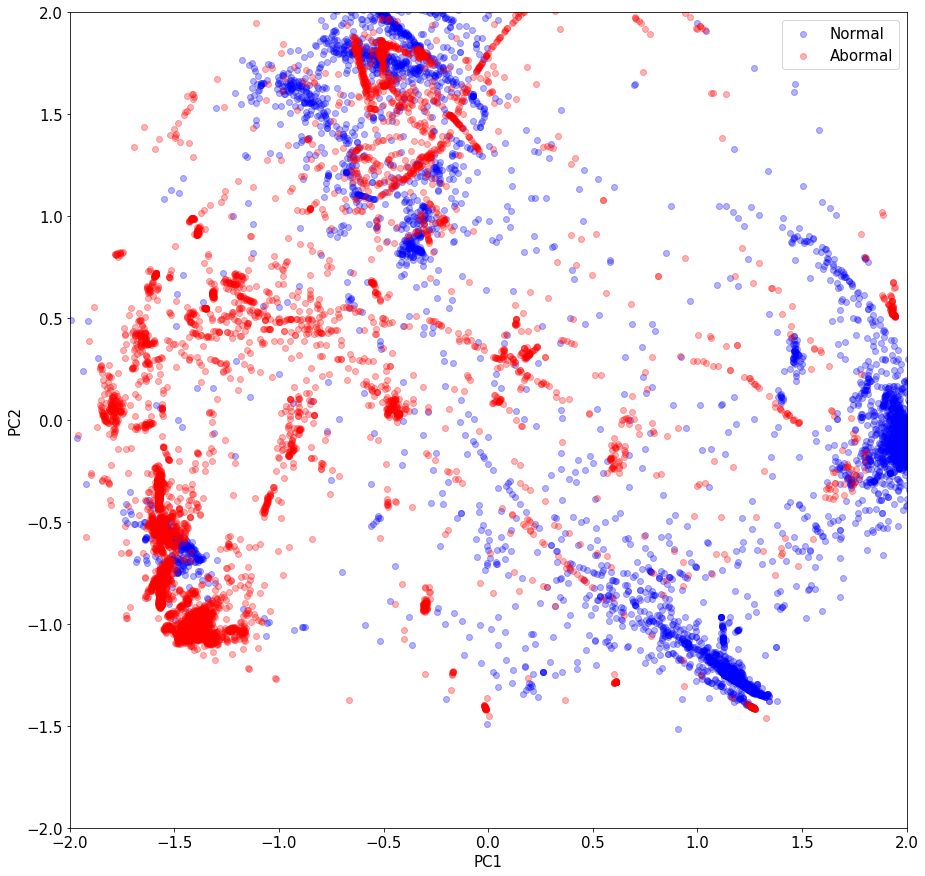

In [45]:
fig = plt.figure(figsize=(15, 15))

plt.scatter(
    x=list(map(lambda data: data[0], pca_normal_latent_data_list)),
    y=list(map(lambda data: data[1], pca_normal_latent_data_list)),
    label="Normal",
    color="blue",
    alpha=0.3
)
plt.scatter(
    x=list(map(lambda data: data[0], pca_abnormal_latent_data_list)),
    y=list(map(lambda data: data[1], pca_abnormal_latent_data_list)),
    label="Abormal",
    color="red",
    alpha=0.3
)

plt.xlim(-2, 2)
plt.ylim(-2, 2)

font_size = 15

plt.xlabel("PC1", fontsize=font_size)
plt.ylabel("PC2", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size)

plt.savefig("./plot/ae_latent_2d.png")
plt.show()

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)

pca.fit(best_latent_data_list)
pca_best_latent_data_list = pca.transform(best_latent_data_list)

pca_normal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in 
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 0
]
pca_abnormal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 1
]

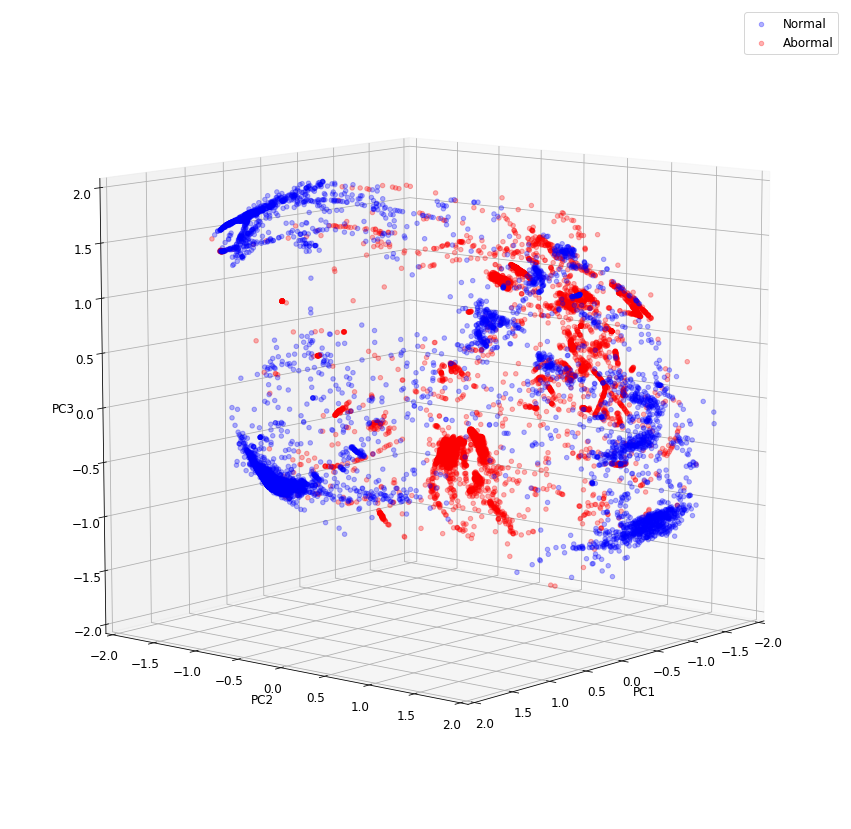

In [46]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')

ax.scatter(
    list(map(lambda data: data[0], pca_normal_latent_data_list)),
    list(map(lambda data: data[1], pca_normal_latent_data_list)),
    list(map(lambda data: data[2], pca_normal_latent_data_list)),
    label="Normal",
    color="blue",
    alpha=0.3
)
ax.scatter(
    list(map(lambda data: data[0], pca_abnormal_latent_data_list)),
    list(map(lambda data: data[1], pca_abnormal_latent_data_list)),
    list(map(lambda data: data[2], pca_abnormal_latent_data_list)),
    label="Abormal",
    color="red",
    alpha=0.3
)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

font_size = 12

ax.set_xlabel("PC1", fontsize=font_size)
ax.set_ylabel("PC2", fontsize=font_size)
ax.set_zlabel("PC3", fontsize=font_size)
ax.tick_params(axis="x", labelsize=font_size)
ax.tick_params(axis="y", labelsize=font_size)
ax.tick_params(axis="z", labelsize=font_size)
ax.legend(fontsize=font_size)

# ax.view_init(elev=10., azim=50)
ax.view_init(elev=10., azim=40)

plt.savefig("./plot/ae_latent_3d.png")
plt.show()